In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Pre Analysis of Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
import pandas as pd

file_path = "/kaggle/input/promoter-gene-prediction/promoters.data"

# 1. Load using comma as separator
# The dataset has 3 columns: Class (+/-), ID/Name, and the DNA Sequence
data = pd.read_csv(file_path, header=None, sep=',')

# 2. Rename columns for clarity
data.columns = ['Class', 'ID', 'Sequence']

# 3. Clean the 'Sequence' column (it often contains tabs/spaces)
data['Sequence'] = data['Sequence'].str.replace('\t', '', regex=False).str.strip()

print(data.shape)
data.head()

(106, 3)


,Class,ID,Sequence
0,+,S10,tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1,+,AMPC,tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2,+,AROH,gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3,+,DEOP2,aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4,+,LEU1_TRNA,tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...


In [6]:
print("Shape of dataset:", data.shape)


Shape of dataset: (106, 3)


In [8]:
# Convert class labels to binary
labels = data['Class'].map({'+': 1, '-': 0})

# Extract DNA sequences
sequences = data['Sequence'].str.upper()

labels.head(), sequences.head()


(0    1
 1    1
 2    1
 3    1
 4    1
 Name: Class, dtype: int64,
 0    TACTAGCAATACGCTTGCGTTCGGTGGTTAAGTATGTATAATGCGC...
 1    TGCTATCCTGACAGTTGTCACGCTGATTGGTGTCGTTACAATCTAA...
 2    GTACTAGAGAACTAGTGCATTAGCTTATTTTTTTGTTATCATGCTA...
 3    AATTGTGATGTGTATCGAAGTGTGTTGCGGAGTAGATGTTAGAATA...
 4    TCGATAATTAACTATTGACGAAAAGCTGAAAACCACTAGAATGCGC...
 Name: Sequence, dtype: object)

In [9]:
# Number of samples
print("Total samples:", len(sequences))

# Sequence length consistency
sequence_lengths = sequences.apply(len)
print("Unique sequence lengths:", sequence_lengths.unique())

# Class balance
print(labels.value_counts())


Total samples: 106
Unique sequence lengths: [57]
Class
1    53
0    53
Name: count, dtype: int64


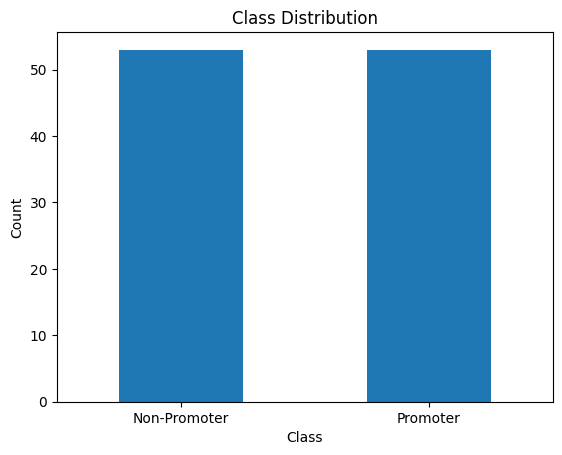

In [10]:
import matplotlib.pyplot as plt

labels.value_counts().plot(kind='bar')
plt.xticks([0,1], ['Non-Promoter', 'Promoter'], rotation=0)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


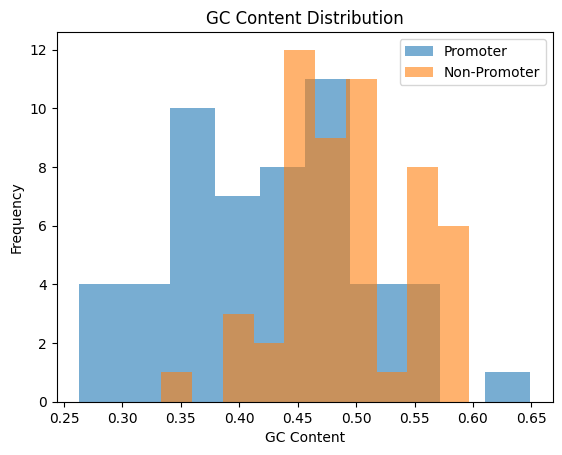

In [12]:
def gc_content(seq):
    return (seq.count('G') + seq.count('C')) / len(seq)

gc_values = sequences.apply(gc_content)

promoter_gc = gc_values[labels == 1]
non_promoter_gc = gc_values[labels == 0]


plt.figure()
plt.hist(promoter_gc, alpha=0.6, label='Promoter')
plt.hist(non_promoter_gc, alpha=0.6, label='Non-Promoter')
plt.xlabel("GC Content")
plt.ylabel("Frequency")
plt.title("GC Content Distribution")
plt.legend()
plt.show()


In [13]:
import numpy as np

bases = ['A', 'C', 'G', 'T']
seq_length = len(sequences.iloc[0])
position_counts = {b: np.zeros(seq_length) for b in bases}

for seq in sequences:
    for i, base in enumerate(seq):
        if base in bases:
            position_counts[base][i] += 1


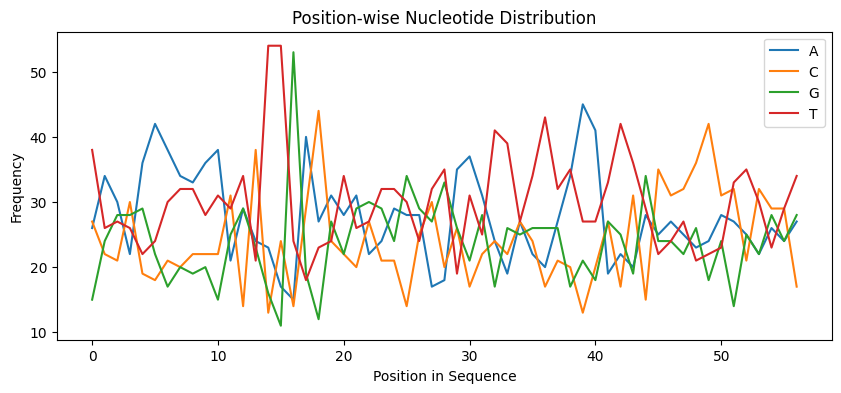

In [14]:
plt.figure(figsize=(10,4))
for base in bases:
    plt.plot(position_counts[base], label=base)

plt.xlabel("Position in Sequence")
plt.ylabel("Frequency")
plt.title("Position-wise Nucleotide Distribution")
plt.legend()
plt.show()


The dataset consists of labeled DNA sequences of equal length, where promoter sequences are denoted by ‘+’ and non-promoter sequences by ‘−’. Exploratory analysis shows distinct nucleotide composition patterns and GC content distributions, suggesting biologically meaningful differences between the two classes.

### DNA ENCODING & FEATURE EXTRACTION

In [15]:
import numpy as np

def one_hot_encode(sequence):
    mapping = {
        'A': [1,0,0,0],
        'C': [0,1,0,0],
        'G': [0,0,1,0],
        'T': [0,0,0,1]
    }
    return np.array([mapping[base] for base in sequence])


In [16]:
one_hot_encode(sequences.iloc[0]).shape


(57, 4)

In [18]:
def eiip_encode(sequence):
    eiip_map = {
        'A': 0.1260,
        'C': 0.1340,
        'G': 0.0806,
        'T': 0.1335
    }
    return np.array([eiip_map[base] for base in sequence])


In [19]:
eiip_signal = eiip_encode(sequences.iloc[0])
eiip_signal[:10], eiip_signal.shape


(array([0.1335, 0.126 , 0.134 , 0.1335, 0.126 , 0.0806, 0.134 , 0.126 ,
        0.126 , 0.1335]),
 (57,))

### FFT feature extraction

Why FFT?

Promoter regions show periodic patterns

FFT captures frequency-domain characteristics

Strong biological interpretation

In [20]:
from scipy.fft import fft

def fft_features(signal):
    fft_vals = np.abs(fft(signal))
    
    features = [
        np.mean(fft_vals),        # average spectral energy
        np.max(fft_vals),         # dominant frequency magnitude
        np.var(fft_vals)          # spectral variance
    ]
    
    return np.array(features)


In [21]:
fft_features(eiip_signal)


array([0.27781631, 6.6327    , 0.72607497])

#### k-mer Frequency Features

In [22]:
from itertools import product

def kmer_features(sequence, k=2):
    kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    counts = dict.fromkeys(kmers, 0)
    
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer in counts:
            counts[kmer] += 1
    
    total = sum(counts.values())
    return np.array([counts[k]/total for k in kmers])


In [23]:
kmer_features(sequences.iloc[0]).shape


(16,)

In [24]:
X = []
for seq in sequences:
    eiip = eiip_encode(seq)
    fft_feat = fft_features(eiip)
    kmer_feat = kmer_features(seq, k=2)
    
    features = np.concatenate([fft_feat, kmer_feat])
    X.append(features)

X = np.array(X)
y = labels.values

X.shape, y.shape


((106, 19), (106,))

DNA sequences were numerically encoded using EIIP mapping to enable signal processing analysis. Spectral features were extracted using Fast Fourier Transform (FFT), capturing frequency-domain characteristics. Additionally, 2-mer frequency features were computed to represent local nucleotide patterns. These biologically motivated features were concatenated to form the final feature vector for classification.

### MODEL TRAINING & EVALUATION

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((84, 19), (22, 19))

In [26]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [27]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=[
    "Non-Promoter", "Promoter"
]))


              precision    recall  f1-score   support

Non-Promoter       0.88      0.64      0.74        11
    Promoter       0.71      0.91      0.80        11

    accuracy                           0.77        22
   macro avg       0.79      0.77      0.77        22
weighted avg       0.79      0.77      0.77        22



In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm


array([[ 7,  4],
       [ 1, 10]])

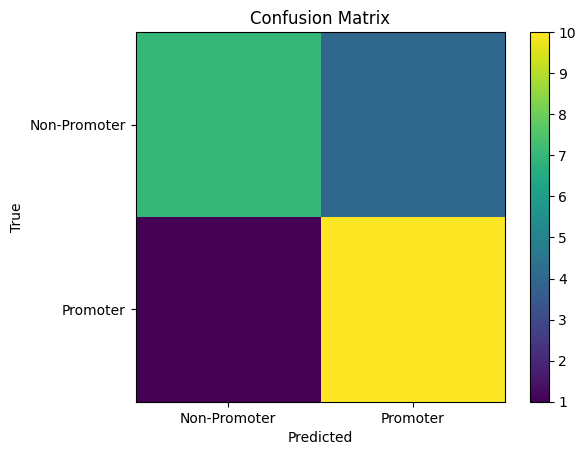

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks([0,1], ['Non-Promoter', 'Promoter'])
plt.yticks([0,1], ['Non-Promoter', 'Promoter'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


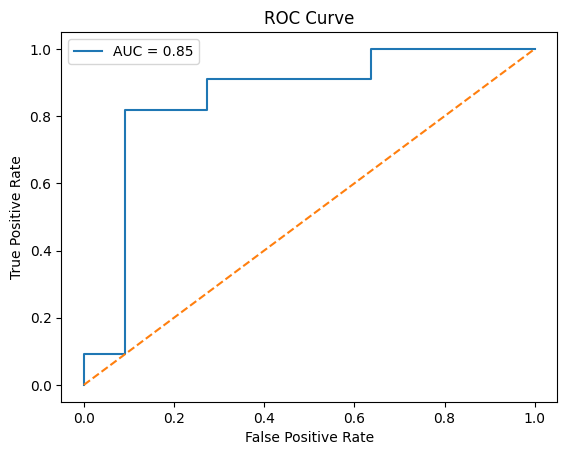

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
